In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn_pandas import DataFrameMapper
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter
import math
import scipy
from sklearn.manifold import TSNE
import seaborn as sns
from lifelines import CoxPHFitter
import seaborn as sns

# human selected predictors

In [5]:
data = pd.read_parquet('/well/rahimi/users/sev854/project/EHRPretrain/data/Predictor_evaluation_1.parquet')

## Kmeans
1. normalise data

In [6]:
cols_standardize = ['age', 'systolic', 'sodium', 'hdl_r']
cols_minMaxStandardize = ['gender','imd2015_5', 'smoke']
cols_leave = ['ckd', 'diabetes', 'chd_history', 'antihtn', 'atrial_fibrillation']

standardize = [([col], StandardScaler()) for col in cols_standardize]
minmax = [([col], MinMaxScaler()) for col in cols_minMaxStandardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + minmax + leave)

# normalise x
train = x_mapper.fit_transform(data).astype('float32')

2. find elbow

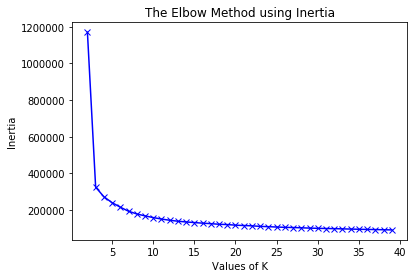

In [27]:
inertias = []
K = range(2, 40)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(train)
    inertias.append(kmeanModel.inertia_)
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [7]:
n = 4
kmeanModel = KMeans(n_clusters=n).fit(train)
data['label'] = kmeanModel.labels_

In [8]:
tsne=TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(train)
plot_df = pd.DataFrame({'X1': X_embedded[:, 0], 'X2': X_embedded[:, 1], 'cluster': kmeanModel.labels_})

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,10), dpi=300)
palette = sns.color_palette("Paired", n)
sns.scatterplot(data=plot_df, x="X1", y="X2", hue="cluster", palette=palette, legend='full')

In [10]:
data.to_parquet('/well/rahimi/users/sev854/project/EHRPretrain/data/analysis/kmeans/label.paruqet')

3. analysis the survival fucntion from two clusters

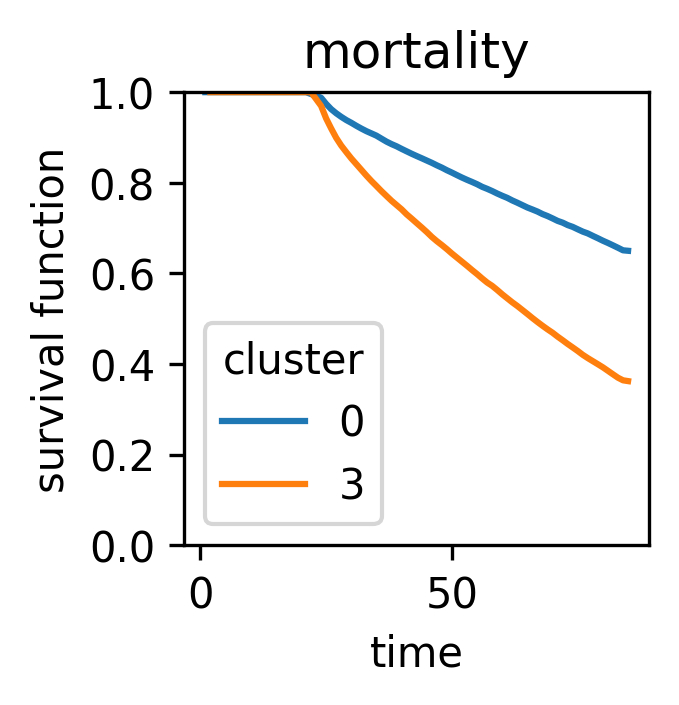

In [28]:
label = [0, 3]

fig = plt.figure(figsize=(2,2), dpi=300)
plot_ax = {}

task_list = ['mortality']

task_map = {
    'mortality': ['event', 'time'],
}

for i, task in enumerate(task_list):
#     print(task)
    plot_ax[i] = fig.add_subplot(int('11{}'.format(i+1)))
    
    for each in label:
        train = data[data['label']==each].reset_index(drop=True)[['age'] + [task_map[task][0], task_map[task][1]]]

#         print('group {}, number of patient: {}'.format(each, len(train)))
        cph = CoxPHFitter().fit(train, task_map[task][1], task_map[task][0])
        surv = cph.baseline_survival_
        plot_ax[i].plot(surv.index.values, surv.values, '-',label=each)
#     plot_ax[i].legend(title='cluster')
    plot_ax[i].set_title(task)
    plot_ax[i].set_ylim(0, 1)
    plot_ax[i].set_ylabel('survival function')
    plot_ax[i].set_xlabel('time')
    plot_ax[i].legend(title='cluster')

plt.show()

# pie plot

([<matplotlib.patches.Wedge at 0x2b94af89c7d0>,
 [Text(0.3350644187630951, 1.04772698508674, 'cluster 0'),
  Text(-0.8962858776463958, 0.637708103705473, 'cluster 1'),
  Text(-0.8970672217997646, 0.6366085135877874, 'cluster 2'),
  Text(-0.33377927625396164, -1.048137106844034, 'cluster 3')],
 [Text(0.1827624102344155, 0.571487446410949, '40.1%'),
  Text(-0.4888832059889431, 0.34784078383934885, '0.0%'),
  Text(-0.4893093937089625, 0.3472410074115203, '0.0%'),
  Text(-0.18206142341125178, -0.5717111491876548, '59.8%')])

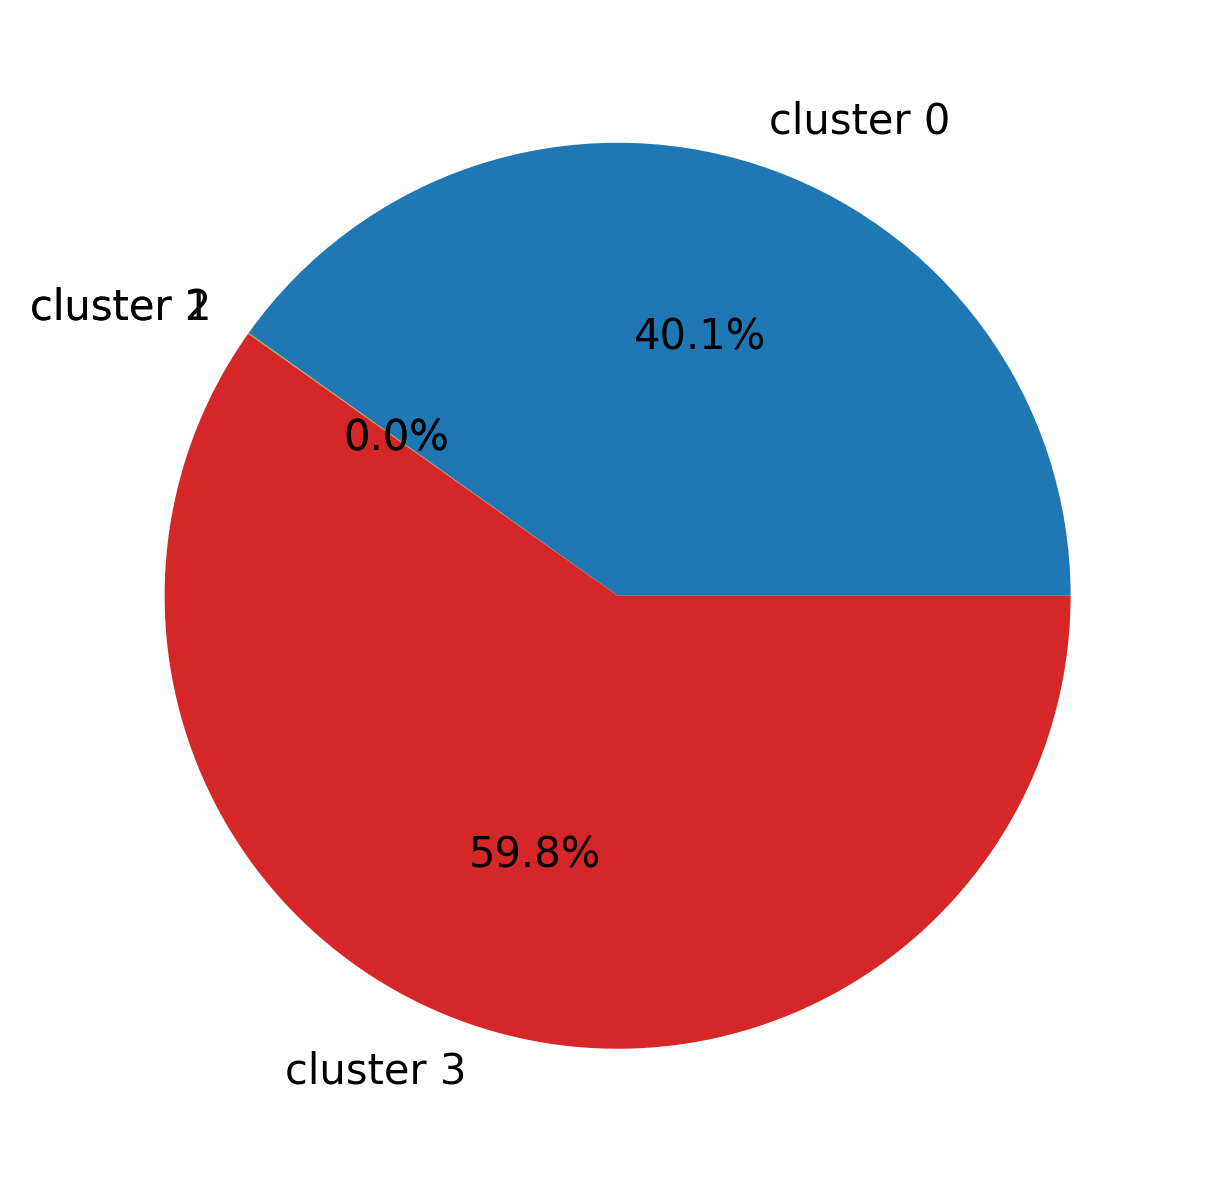

In [20]:
label = range(4)
plt.figure(figsize=(5,5), dpi=300)
pat_len = []
labels = []
for each in label:
    pat_len.append(len(data[data['label']==each]))
    labels.append('cluster {}'.format(each))
plt.pie(x=pat_len, autopct="%.1f%%", labels=labels)

# evaluation 1

Text(0.5, 99.66666666666667, 'cluster')

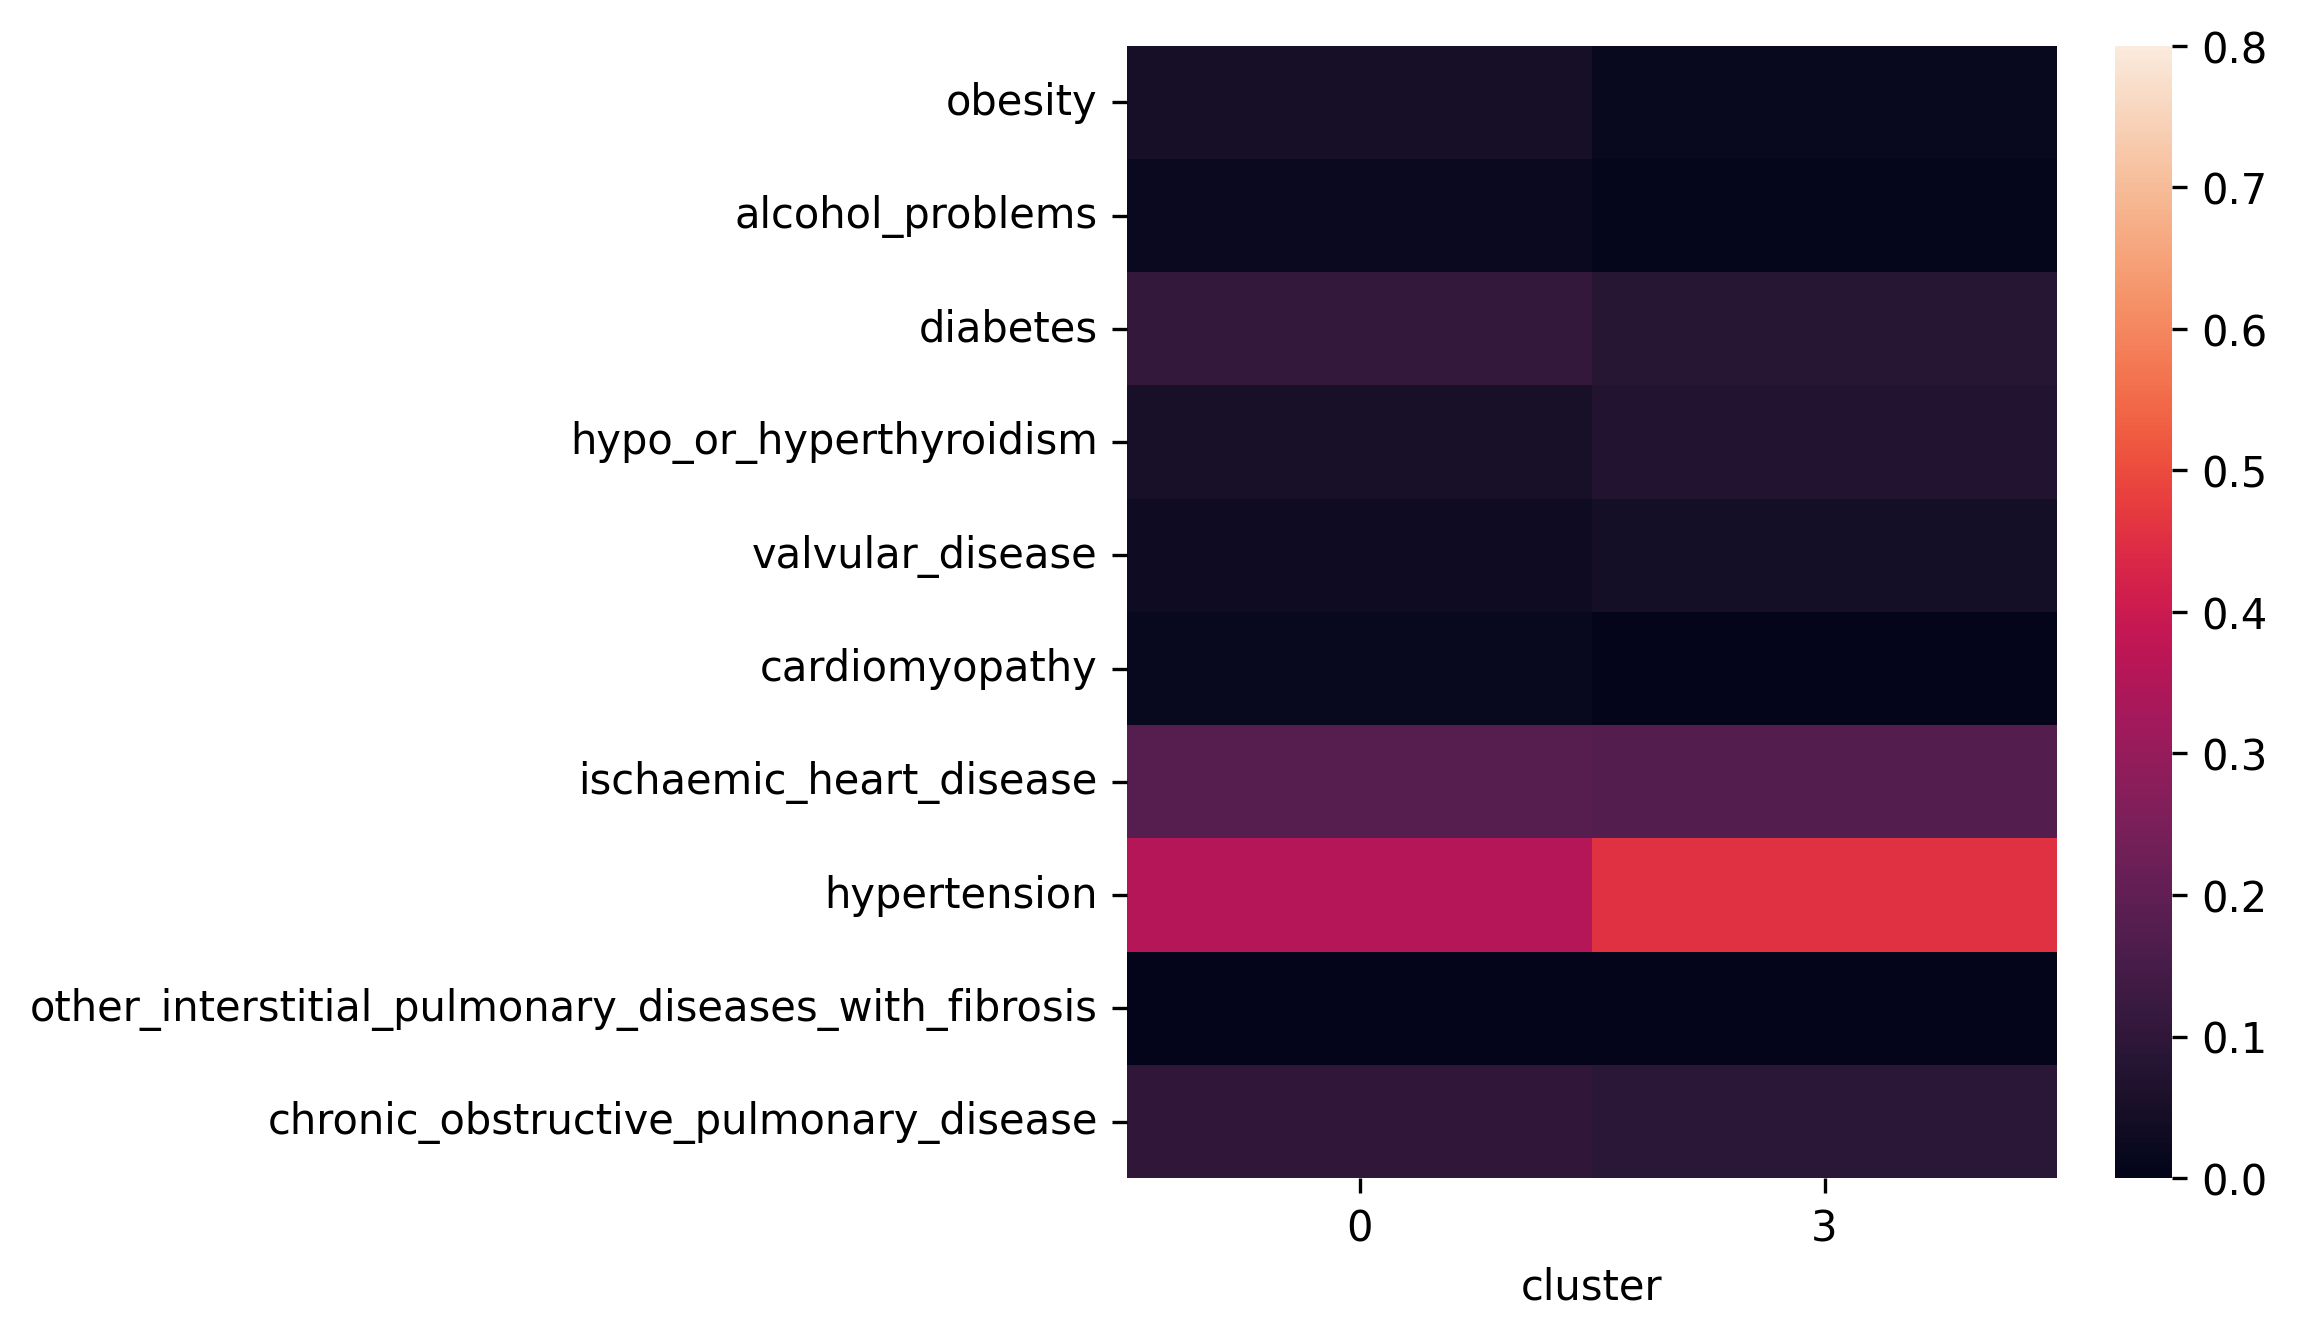

In [29]:
feature = ['obesity', 'alcohol problems', 'diabetes', 'hypo or hyperthyroidism',
          'valvular disease', 'cardiomyopathy', 'ischaemic heart disease',
          'hypertension', 'other interstitial pulmonary diseases with fibrosis', 'chronic obstructive pulmonary disease']

feature = ['_'.join(each.split()) for each in feature]

co_matrix = []

label = [0, 3]

for cluster in label:
    prev = []
    tmp = data[data['label']==cluster]
    for col in feature:
        des = tmp[col].values
        prev.append(sum(des)/len(des))
    co_matrix.append(prev)

# co prevalence matrix with row as group and col as feature
co_matrix = np.transpose(np.array(co_matrix))

plt.figure(figsize=(5,5), dpi=300)
sns.heatmap(co_matrix, xticklabels=[str(each) for each in label], yticklabels=feature, vmin=0, vmax=0.8)
plt.xlabel('cluster')